In [36]:
import heapq
from collections import defaultdict, Counter
import networkx as nx
import matplotlib.pyplot as plt

class ChinesePostman:
    def __init__(self):
        self.graph = defaultdict(list)
        self.edges = []

    def add_node(self, u, v, weight):
        self.graph[u].append((v, weight))
        self.graph[v].append((u, weight))
        self.edges.append((u, v, weight))

    def dijkstra(self, start):
        distances = {node: float('inf') for node in self.graph}
        distances[start] = 0
        priority_queue = [(0, start)]
        while priority_queue:
            current_distance, current_node = heapq.heappop(priority_queue)
            if current_distance > distances[current_node]:
                continue
            for neighbor, weight in self.graph[current_node]:
                distance = current_distance + weight
                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    heapq.heappush(priority_queue, (distance, neighbor))
        return distances

    def find_shortest_path(self, start, end):
        """Find shortest path using Dijkstra's algorithm."""
        distances = {node: float('inf') for node in self.graph}
        distances[start] = 0
        predecessors = {node: None for node in self.graph}
        priority_queue = [(0, start)]

        while priority_queue:
            current_distance, current_node = heapq.heappop(priority_queue)
            if current_distance > distances[current_node]:
                continue
            if current_node == end:
                break
            
            for neighbor, weight in self.graph[current_node]:
                distance = current_distance + weight
                if distance < distances[neighbor]:
                    distances[neighbor] = distance
                    predecessors[neighbor] = current_node
                    heapq.heappush(priority_queue, (distance, neighbor))

        # Reconstruct path
        path = []
        current = end
        while current is not None:
            path.append(current)
            current = predecessors[current]
        path.reverse()

        return distances[end], path

    def find_odd_degree_nodes(self):
        degree_count = Counter()
        for u, v, _ in self.edges:
            degree_count[u] += 1
            degree_count[v] += 1
        return [node for node, degree in degree_count.items() if degree % 2 != 0]

    def solve(self):
        """Solve the Chinese Postman Problem."""
        # Find vertices with odd degree
        odd_vertices = self.find_odd_degree_nodes()
        
        # If no odd vertices, the original graph has an Eulerian circuit
        if not odd_vertices:
            path = self.find_eulerian_path(self.graph)
            total_cost = sum(weight for _, _, weight in self.edges)
            return total_cost, path
                
        # Find minimum weight perfect matching for odd vertices
        min_weight_matches = self.find_min_weight_matching(odd_vertices)
        
        # Create augmented graph by adding edges from matching
        augmented_graph = defaultdict(list)
        for v1, v2 in self.graph.items():
            augmented_graph[v1] = v2.copy()
                
        additional_cost = 0
        for v1, v2, weight in min_weight_matches:
            # Get the actual path between v1 and v2
            _, path = self.find_shortest_path(v1, v2)
            
            # Add all edges along the path
            for i in range(len(path)-1):
                start, end = path[i], path[i+1]
                # Find the weight of this edge in original graph
                for neighbor, w in self.graph[start]:
                    if neighbor == end:
                        edge_weight = w
                        break
                augmented_graph[start].append((end, edge_weight))
                augmented_graph[end].append((start, edge_weight))
                additional_cost += edge_weight
                
        # Find Eulerian circuit in the augmented graph
        path = self.find_eulerian_path(augmented_graph)
        total_cost = sum(weight for _, _, weight in self.edges) + additional_cost
        
        return total_cost, path

    def find_min_weight_matching(self, odd_vertices):
        """Find minimum weight perfect matching for odd degree vertices."""
        matches = []
        vertices = odd_vertices.copy()
        
        while vertices:
            v1 = vertices[0]
            min_cost = float('inf')
            min_v2 = None
            
            for v2 in vertices[1:]:
                # Get distance and path from find_shortest_path
                distance, path = self.find_shortest_path(v1, v2)
                # Compare only the distance part
                if distance < min_cost:
                    min_cost = distance
                    min_v2 = v2
                    
            matches.append((v1, min_v2, min_cost))
            vertices.remove(v1)
            vertices.remove(min_v2)
        
        return matches

    def find_eulerian_path(self, graph=None, start_vertex=None):
        """Find Eulerian path using Hierholzer's algorithm."""
        if graph is None:
            graph = self.graph
        
        if not start_vertex:
            start_vertex = list(graph.keys())[0]
            
        # Create copy of graph for modification
        curr_graph = {}
        for v in graph:
            curr_graph[v] = graph[v].copy()
            
        path = []
        stack = [start_vertex]
        
        while stack:
            curr_v = stack[-1]
            
            if curr_graph[curr_v]:
                # Take an edge
                next_v = curr_graph[curr_v][0][0]
                weight = curr_graph[curr_v][0][1]
                curr_graph[curr_v].remove((next_v, weight))
                curr_graph[next_v].remove((curr_v, weight))
                stack.append(next_v)
            else:
                # No more edges - add to path
                path.append(stack.pop())
                
        return path[::-1]

    def plot_route(self):
        G = nx.Graph()
        for u, v, weight in self.edges:
            G.add_edge(u, v, weight=weight)
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
        edge_labels = {(u, v): f'{weight}' for u, v, weight in self.edges}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()



Optimal Route:
Path: ['A', 'B', 'C', 'D', 'A', 'C', 'A']
Total cost: 16



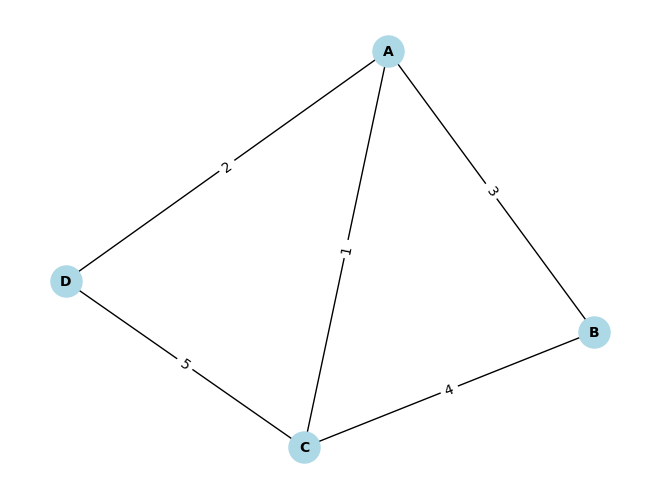

In [37]:
cpp = ChinesePostman()
cpp.add_node('A', 'B', 3)
cpp.add_node('B', 'C', 4)
cpp.add_node('C', 'D', 5)
cpp.add_node('D', 'A', 2)
cpp.add_node('A', 'C', 1)

total_cost, path = cpp.solve()
print(f"\nOptimal Route:")
print(f"Path: {path}")
print(f"Total cost: {total_cost}\n")
cpp.plot_route()



Optimal Route:
Path: [1, 2, 3, 1, 5, 4, 2, 4, 3, 1]
Total cost: 40



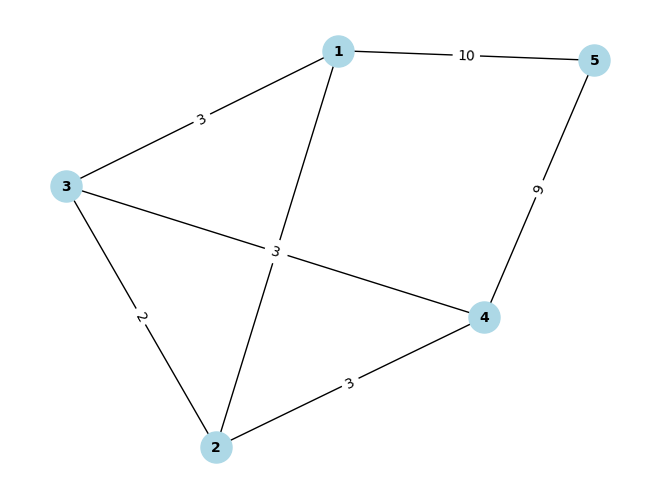

In [38]:
## ice_cream = sailboat = [(1,2,4), (1,3,3), (1,5,10), (2,3,2), (2,4,3), (3,4,3), (4,5,9)]
cpp = ChinesePostman()
cpp.add_node(1, 2, 4)
cpp.add_node(1, 3, 3)
cpp.add_node(1, 5, 10)
cpp.add_node(2, 3, 2)
cpp.add_node(2, 4, 3)
cpp.add_node(3, 4, 3)
cpp.add_node(4, 5, 9)

total_cost, path = cpp.solve()
print(f"\nOptimal Route:")
print(f"Path: {path}")
print(f"Total cost: {total_cost}\n")
cpp.plot_route()



Optimal Route:
Path: [1, 2, 3, 4, 5, 1, 8, 7, 2, 3, 6, 4, 6, 5, 7, 8, 1]
Total cost: 64



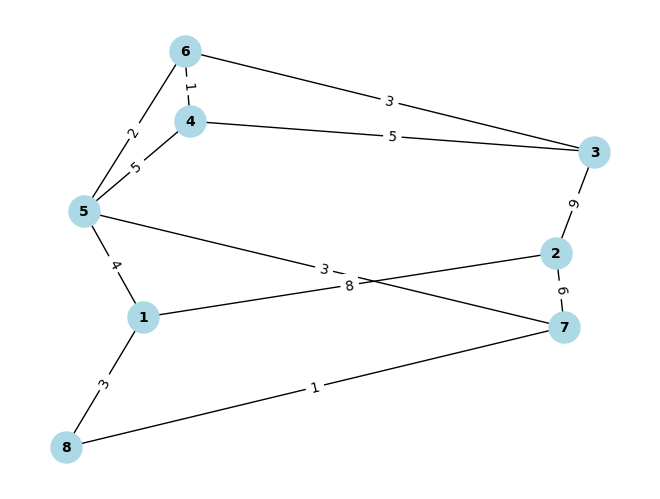

In [39]:
# big_six = [
#     (1,2,8), (1,5,4), (1,8,3), (2,3,9), (2,7,6), (3,4,5),
#     (3,6,3), (4,5,5), (4,6,1), (5,6,2), (5,7,3), (7,8,1),
# ]
cpp = ChinesePostman()
cpp.add_node(1, 2, 8)
cpp.add_node(1, 5, 4)
cpp.add_node(1, 8, 3)
cpp.add_node(2, 3, 9)
cpp.add_node(2, 7, 6)
cpp.add_node(3, 4, 5)
cpp.add_node(3, 6, 3)
cpp.add_node(4, 5, 5)
cpp.add_node(4, 6, 1)
cpp.add_node(5, 6, 2)
cpp.add_node(5, 7, 3)
cpp.add_node(7, 8, 1)

total_cost, path = cpp.solve()
print(f"\nOptimal Route:")
print(f"Path: {path}")
print(f"Total cost: {total_cost}\n")
cpp.plot_route()


Optimal Route:
Path: ['Warszawa', 'Kraków', 'Katowice', 'Warszawa', 'Gdańsk', 'Poznań', 'Warszawa', 'Wrocław', 'Poznań', 'Szczecin', 'Poznań', 'Wrocław', 'Katowice', 'Warszawa']
Total cost: 3390



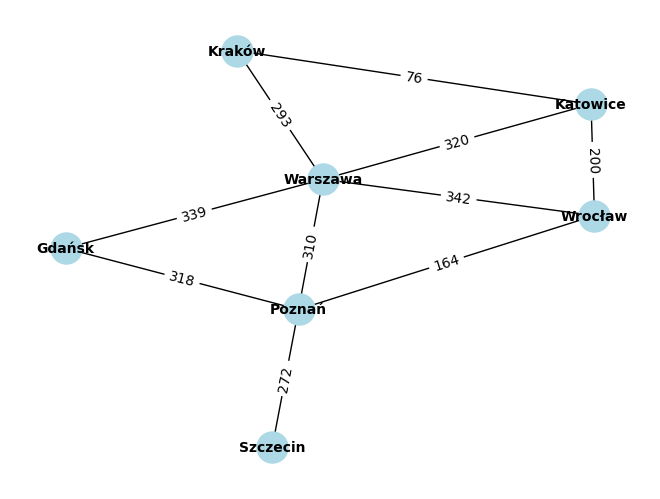

In [40]:
cpp = ChinesePostman()
cpp.add_node('Warszawa', 'Kraków', 293)
cpp.add_node('Warszawa', 'Gdańsk', 339)
cpp.add_node('Warszawa', 'Wrocław', 342)
cpp.add_node('Warszawa', 'Katowice', 320)
cpp.add_node('Warszawa', 'Poznań', 310)
cpp.add_node('Gdańsk', 'Poznań', 318)
cpp.add_node('Wrocław', 'Poznań', 164)
cpp.add_node('Wrocław', 'Katowice', 200)
cpp.add_node('Poznań', 'Szczecin', 272)
cpp.add_node('Katowice', 'Kraków', 76)


total_cost, path = cpp.solve()
print(f"\nOptimal Route:")
print(f"Path: {path}")
print(f"Total cost: {total_cost}\n")
cpp.plot_route()

In [47]:
def test_chinese_postman():
    cpp = ChinesePostman()
    cpp.add_node(1, 2, 4)
    cpp.add_node(1, 3, 3)
    cpp.add_node(1, 5, 10)
    cpp.add_node(2, 3, 2)
    cpp.add_node(2, 4, 3)
    cpp.add_node(3, 4, 3)
    cpp.add_node(4, 5, 9)

    total_cost, path = cpp.solve()
    assert total_cost == 40
    assert path == [1, 2, 3, 1, 5, 4, 2, 4, 3, 1]
    
    cpp = ChinesePostman()
    cpp.add_node('A', 'B', 3)
    cpp.add_node('B', 'C', 4)
    cpp.add_node('C', 'D', 5)
    cpp.add_node('D', 'A', 2)
    cpp.add_node('A', 'C', 1)

    total_cost, path = cpp.solve()
    assert total_cost == 16
    assert path == ['A', 'B', 'C', 'D', 'A', 'C', 'A']

    cpp = ChinesePostman()
    cpp.add_node(1, 2, 8)
    cpp.add_node(1, 5, 4)
    cpp.add_node(1, 8, 3)
    cpp.add_node(2, 3, 9)
    cpp.add_node(2, 7, 6)
    cpp.add_node(3, 4, 5)
    cpp.add_node(3, 6, 3)
    cpp.add_node(4, 5, 5)
    cpp.add_node(4, 6, 1)
    cpp.add_node(5, 6, 2)
    cpp.add_node(5, 7, 3)
    cpp.add_node(7, 8, 1)

    total_cost, path = cpp.solve()
    assert total_cost == 64
    assert path == [1, 2, 3, 4, 5, 1, 8, 7, 2, 3, 6, 4, 6, 5, 7, 8, 1]

    cpp = ChinesePostman()
    cpp.add_node('Warszawa', 'Kraków', 293)
    cpp.add_node('Warszawa', 'Gdańsk', 339)
    cpp.add_node('Warszawa', 'Wrocław', 342)
    cpp.add_node('Warszawa', 'Katowice', 320)
    cpp.add_node('Warszawa', 'Poznań', 310)
    cpp.add_node('Gdańsk', 'Poznań', 318)
    cpp.add_node('Wrocław', 'Poznań', 164)
    cpp.add_node('Wrocław', 'Katowice', 200)
    cpp.add_node('Poznań', 'Szczecin', 272)
    cpp.add_node('Katowice', 'Kraków', 76)

    total_cost, path = cpp.solve()
    assert total_cost == 3390
    assert path == ['Warszawa', 'Kraków', 'Katowice', 'Warszawa', 'Gdańsk', 'Poznań', 'Warszawa', 'Wrocław', 'Poznań', 'Szczecin', 'Poznań', 'Wrocław', 'Katowice', 'Warszawa']

    print("All tests passed successfully!")

test_chinese_postman()

All tests passed successfully!
